In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import bernoulli
from scipy.stats import beta
import seaborn as sns
sns.set()
sns.set_context("talk")
%matplotlib inline

# We have some data providing the results of 30 coin tosses. We would like to estimate how fair the coin is, i.e. what is the probability of getting heads (1).

In [2]:
data = [1,0,1,0,0,1,1,1,0,0,1,1,1,0,1,1,1,0,0,1,1,0,1,1,0,1,1,0,1,1]
print(len(data))

30


## We build a probabilistic model of coin tossing. 
All coin tosses are supposed to be independent tosses of the same coin, which always have the same probability of returning a head.
We want to perform Bayesian inference, therefore we need a prior.
For inference, we will be using Metropolis MCMC. 

## Defining a prior
We need to put some prior probability on the fairness of the coin. For this, a beta distribution seems appropriate, as it is a continuous distribution between 0 and 1.
Let's display a beta distribution with various parameter values.

Text(0,0.5,'Density/Frequency')

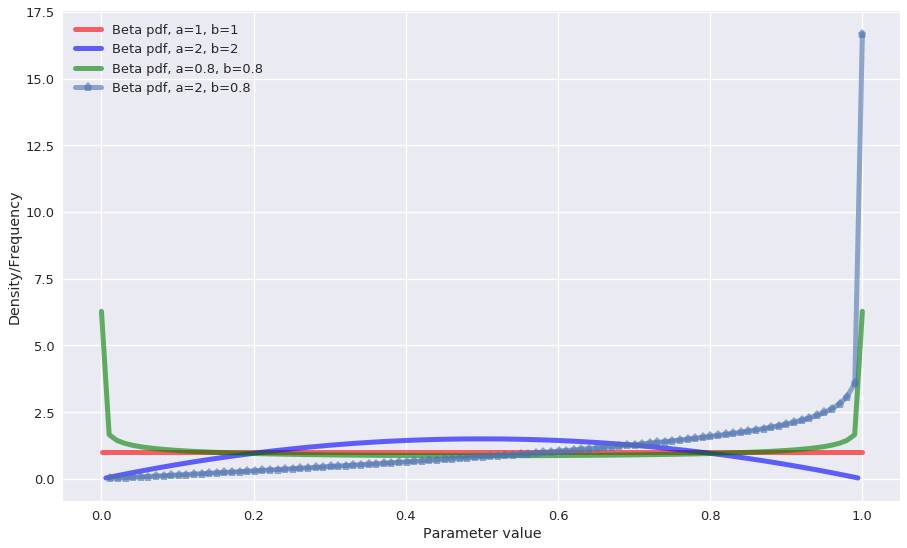

In [3]:
fig_size=[]
fig_size.append(15)
fig_size.append(9)
plt.rcParams["figure.figsize"] = fig_size

beginning = 0.0001
end = 0.9999

a = 1
b = 1
x = np.linspace(beta.ppf(beginning, a, b), beta.ppf(end, a, b), 100)
plt.plot(x, beta.pdf(x, a, b),'r-', lw=5, alpha=0.6, label='Beta pdf, a=1, b=1')
a = 2
b = 2
x2 = np.linspace(beta.ppf(beginning, a, b), beta.ppf(end, a, b), 100)
plt.plot(x2, beta.pdf(x2, a, b),'b-', lw=5, alpha=0.6, label='Beta pdf, a=2, b=2')
a = 0.8
b = 0.8
x3 = np.linspace(beta.ppf(beginning, a, b), beta.ppf(end, a, b), 100)
plt.plot(x3, beta.pdf(x3, a, b),'g-', lw=5, alpha=0.6, label='Beta pdf, a=0.8, b=0.8')
a = 2
b = 0.8
x4 = np.linspace(beta.ppf(beginning, a, b), beta.ppf(end, a, b), 100)
plt.plot(x4, beta.pdf(x4, a, b),'p-', lw=5, alpha=0.6, label='Beta pdf, a=2, b=0.8')
plt.legend(loc='best', frameon=False)
plt.xlabel("Parameter value")
plt.ylabel("Density/Frequency")


### We choose to use a=2, b=2. This is a weakly informative prior that the coin should be fair, given our past experience with coins.

## Inference of the fairness of the coin using MCMC
We build a MCMC chain to estimate the probability of heads for this coin.
First we define the model, with the prior, the likelihood and the posterior probability, then we implement a Metropolis MCMC inference mechanism.

## Building of the model 

In [4]:
# Function to compute the likelihood P(D|M)
def likelihood (data, parameter):
    p = 1.0
    for d in data:
        if d == 0:
            p *= 1-parameter
        else:
            p *= parameter
    return p

# Function to compute the prior P(M)
def prior (parameter):
    return beta.pdf(parameter, a=2, b=2)

# Function to compute the un-normalized posterior P(D|M) * P(M)
def unnormalized_posterior (data, parameter):
    return likelihood(data, parameter) * prior(parameter)

# Function to propose a new parameter value, randomly drawn between 0 and 1
def propose_new_parameter_value():
    return random.random()



## Implementing MCMC

In [5]:
# Function to run Metropolis MCMC inference
def MetropolisMCMC(data, number_iterations):
    current_parameter_value = random.random()
    record_parameter = []
    record_parameter.append(current_parameter_value)
    print("Initial parameter value for the MCMC: "+str(current_parameter_value))
    current_posterior = unnormalized_posterior(data, current_parameter_value)
    print("Initial probability of the model: " + str(current_posterior))
    record_posterior = []
    record_posterior.append(current_posterior)
    for i in range (number_iterations):
        acceptance_threshold = random.random()
        proposed_parameter_value = random.random()
        proposed_posterior = unnormalized_posterior(data, proposed_parameter_value)
        if (proposed_posterior / current_posterior > acceptance_threshold):
            current_parameter_value = proposed_parameter_value
            current_posterior = proposed_posterior
        record_parameter.append(current_parameter_value)
        record_posterior.append(current_posterior)
    return record_parameter, record_posterior


In [6]:
params, posteriors = MetropolisMCMC(data, 10000)

Initial parameter value for the MCMC: 0.5028587210335583
Initial probability of the model: 1.46160117259e-09


Text(0,0.5,'Posterior probability')

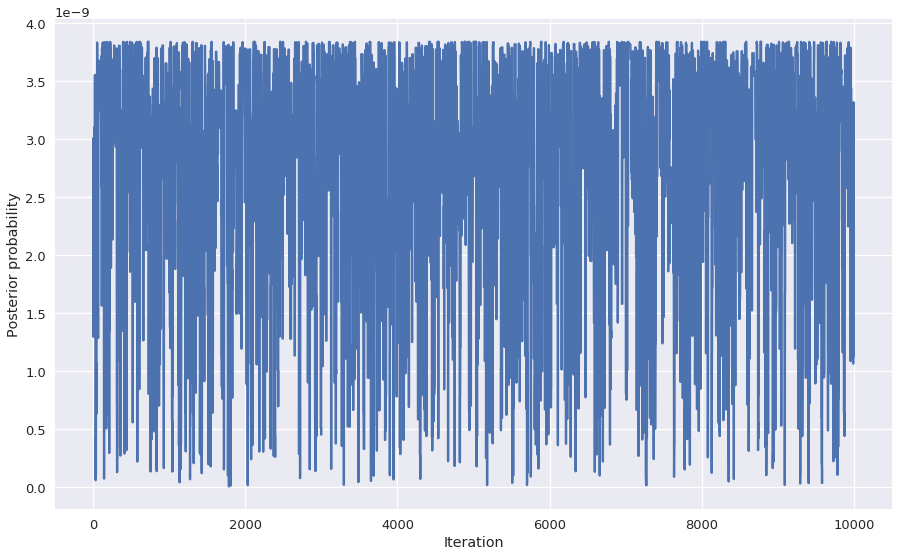

In [7]:
plt.plot(posteriors)
plt.xlabel("Iteration")
plt.ylabel("Posterior probability")


Text(0,0.5,'Parameter value')

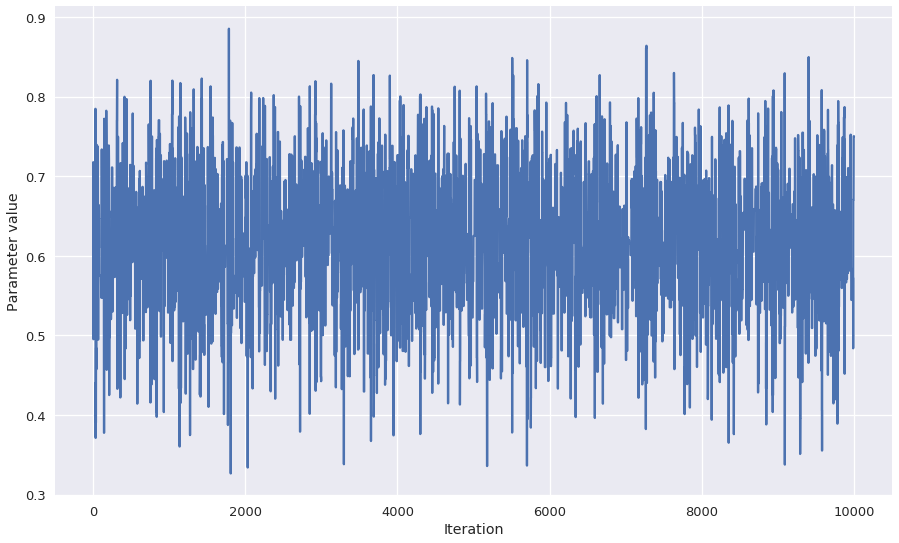

In [8]:
plt.plot(params)
plt.xlabel("Iteration")
plt.ylabel("Parameter value")


## Let's compare the posterior inference to the prior: have we learned anything about our coin?

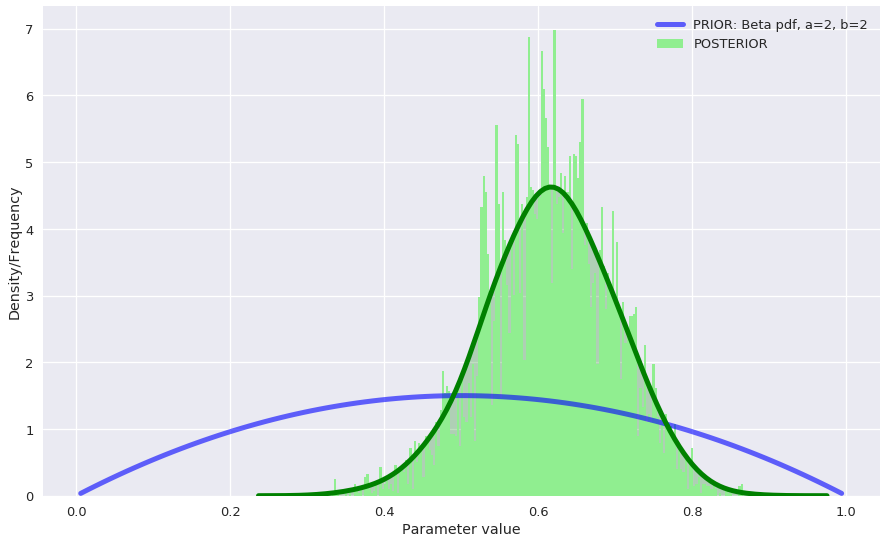

In [9]:
plt.rcParams["figure.figsize"] = fig_size

a = 2
b = 2
x2 = np.linspace(beta.ppf(beginning, a, b), beta.ppf(end, a, b), 100)
plt.plot(x2, beta.pdf(x2, a, b),'b-', lw=5, alpha=0.6, label='PRIOR: Beta pdf, a=2, b=2')
plt.hist(params, label='POSTERIOR', density=True, bins=200, color="lightgreen")
plt.legend(loc='best', frameon=False)
plt.xlabel("Parameter value")
plt.ylabel("Density/Frequency")
sns.kdeplot(np.array(params), bw=0.03, lw=5, color="green", shade=True)


## What is the probability that the coin favours heads over tails?
Let's compute P(parameter > 0.5).

In [10]:
num = 0
for i in range(len(params)):
    if params[i]>0.5:
        num += 1
print("The probability that the coin favours heads is "+str(num / len(params)) + " vs "+str(1-num / len(params)) + " that it favours tails.")

The probability that the coin favours heads is 0.9204079592040796 vs 0.07959204079592042 that it favours tails.


### Our mean estimate for the parameter is:


In [11]:
median_param=np.median(params)
print(str(median_param))

0.616086341786


### Compared to the Maximum Likelihood estimate, the frequency of heads:
    

In [12]:
ratio_1=sum(data)/len(data)
print(str(ratio_1))

0.6333333333333333


## Conclusion
The coin seems to be unfair because it is much more probable that the parameter value is above 0.5 than below. Our estimate of the fairness of the coin has been a little bit affected by our prior, which was weakly informative, as can be seen from the comparison between the median parameter value inferred by MCMC and the Maximum Likelihood inference of the parameter value, the frequency of heads.